#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

Начинаем с добавления необходимых библиотек.

In [1]:
pip install statsmodels -q

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Блок импорта:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor

from sklearn.linear_model import Ridge

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error as mse

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
import lightgbm as lgb

from statsmodels. tsa.stattools import adfuller

Выгрузим данные из файла и посмотрим общую информацию

In [3]:
# Первичная оценка данных:
df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

display(df.head())
df.info()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


Сразу сделали приписку, чтобы засунуть дату и время в индексы. Общее количество строк совпадает с количеством ненулевых, значит, пропусков не наблюдается. Также тип данных указан корректно. Проведём ресемплирование на 1 часу, как было указано в ТЗ.

In [4]:
# Ресемплирование данных:
df.sort_index(inplace=True)
df = df.resample('1H').sum()
display(df.head())

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


### Вывод:
Таблица аналогична тренировочной из модуля, содержит только два столбца: дату и время и количество поездок. Первый был сразу переведён в индексы. Пропусков в таблице не обнаружено, тип данных корректен.

Также согласно ТЗ произвели ресемплирование по каждому часу.

## Анализ

Весь анализ будет заключаться в прочтении построенных графиков, а также добавление и описании скользящей средней, определении трендов и сезонности.

Для начала построим график по всему объёму данных.

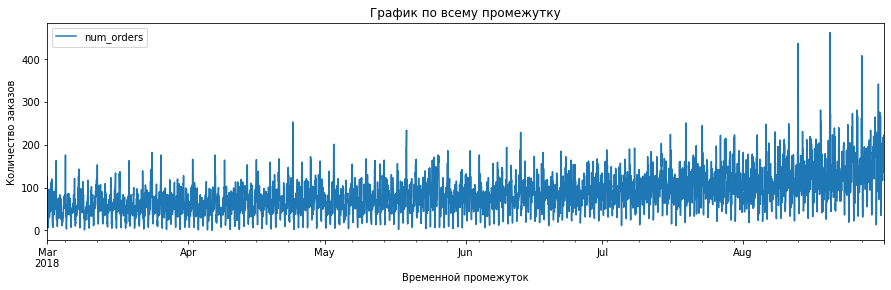

In [5]:
# График по всему периоду:
df.plot(figsize = (15, 4))
plt.title('График по всему промежутку')
plt.ylabel('Количество заказов')
plt.xlabel('Временной промежуток')
plt.show()

Итак, нам достались данные за март по август (включительно) 2018 года. До августа график выглядел весьма стабильно, однако в последний месяц лета начались явные всплески заказов. Рассмотрим его подробнее.

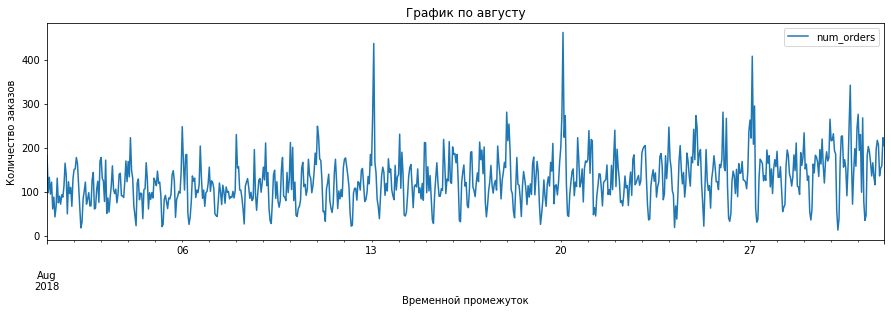

In [6]:
# График по августу:
df_aug = df['2018-08-01':]
df_aug.plot(figsize = (15, 4))
plt.title('График по августу')
plt.ylabel('Количество заказов')
plt.xlabel('Временной промежуток')
plt.show()

Видим три всплеска, приходящихся на 13, 20 и 27 числа. Открыв календарь, понимаем, что это понедельники. Посмотрим более детально последние дни, например, неделю.

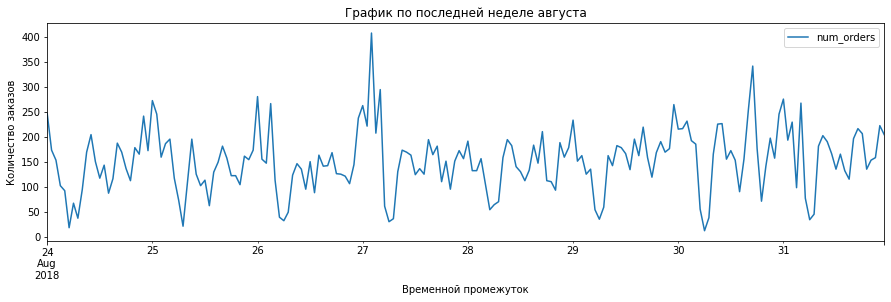

In [7]:
# График по последней неделе агуста:
df_aug_lw = df['2018-08-24':]
df_aug_lw.plot(figsize = (15, 4))
plt.title('График по последней неделе августа')
plt.ylabel('Количество заказов')
plt.xlabel('Временной промежуток')
plt.show()

С понедельника по пятницу количество заказов было примерно одинаковым, к выходным виден рост. Также наблюдается циклический спад, построим почасовой график.

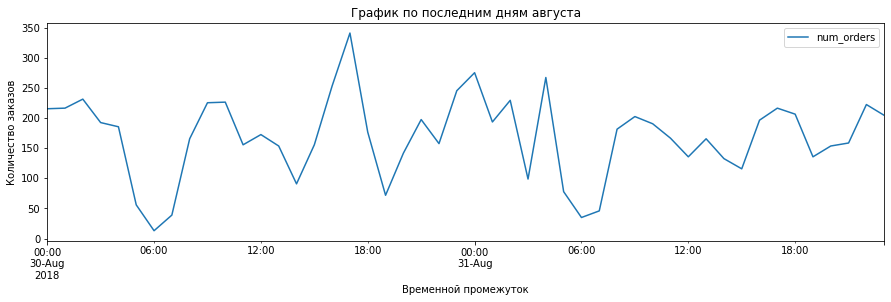

In [8]:
# График по последним дням агуста:
df_aug_ld = df['2018-08-30':]
df_aug_ld.plot(figsize = (15, 4))
plt.title('График по последним дням августа')
plt.ylabel('Количество заказов')
plt.xlabel('Временной промежуток')
plt.show()

Регулярный спад приходится на раннее утро, около 6 часов.

#### Промежуточный вывод:
Данные за март по август (включительно) 2018 года. До августа график выглядел весьма стабильно, однако в последний месяц лета начались явные всплески заказов.

На графике за август видим три всплеска, приходящихся на 13, 20 и 27 числа. Открыв календарь, понимаем, что это понедельники. 

На последней неделе с понедельника по пятницу количество заказов было примерно одинаковым, к выходным виден рост. Также наблюдается циклический спад. Он спад приходится на раннее утро, около 6 часов.

Теперь добавим на графики скользящую среднюю с окном в 10 измерений для оптимального сглаживания колебаний величины.

In [9]:
# Добавление скользящей:
df['rolling_mean'] = df.shift().rolling(10).mean()

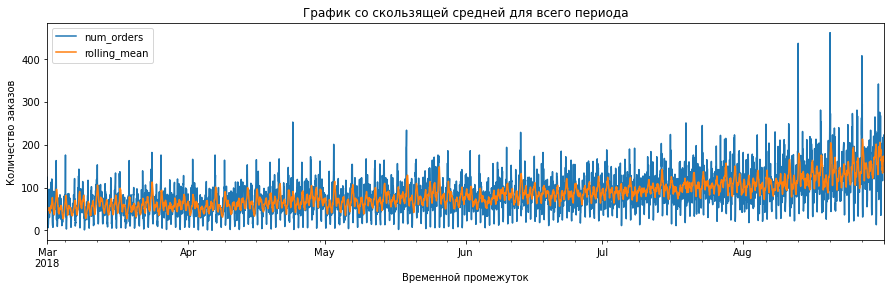

In [10]:
# Построение графика:
df.plot(figsize = (15, 4))
plt.title('График со скользящей средней для всего периода')
plt.ylabel('Количество заказов')
plt.xlabel('Временной промежуток')
plt.show()

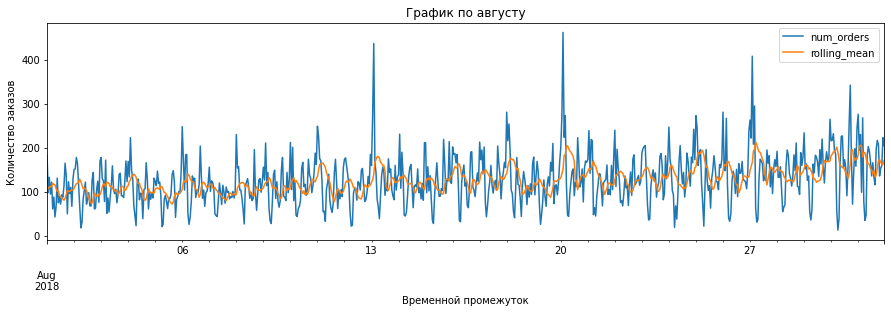

In [11]:
# График по августу:
df_aug = df['2018-08-01':]
df_aug.plot(figsize = (15, 4))
plt.title('График по августу')
plt.ylabel('Количество заказов')
plt.xlabel('Временной промежуток')
plt.show()

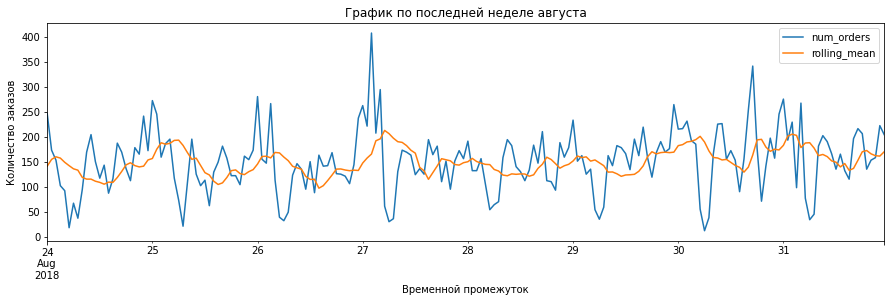

In [12]:
# График по последней неделе агуста:
df_aug_lw = df['2018-08-24':]
df_aug_lw.plot(figsize = (15, 4))
plt.title('График по последней неделе августа')
plt.ylabel('Количество заказов')
plt.xlabel('Временной промежуток')
plt.show()

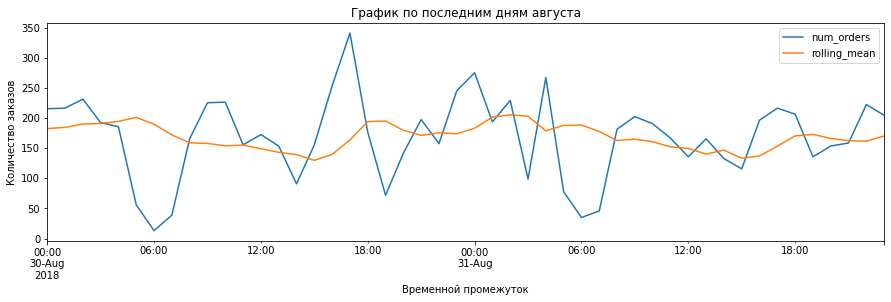

In [13]:
# График по последним дням агуста:
df_aug_ld = df['2018-08-30':]
df_aug_ld.plot(figsize = (15, 4))
plt.title('График по последним дням августа')
plt.ylabel('Количество заказов')
plt.xlabel('Временной промежуток')
plt.show()

#### Промежуточный вывод:
Для оптимального сглаживания колебаний подошла скользящая с окном в 10 измерений.

Теперь поработаем с трендами и сезонностью, для этого используем готовую функцию.

In [14]:
# Декомпозируем данные:
decomposed = seasonal_decompose(df.num_orders)
decomposed_aug = seasonal_decompose(df_aug.num_orders)
decomposed_aug_lw = seasonal_decompose(df_aug_lw.num_orders)
decomposed_aug_ld = seasonal_decompose(df_aug_ld.num_orders)

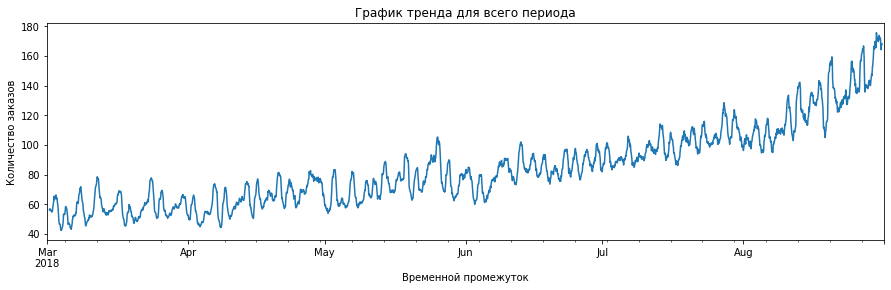

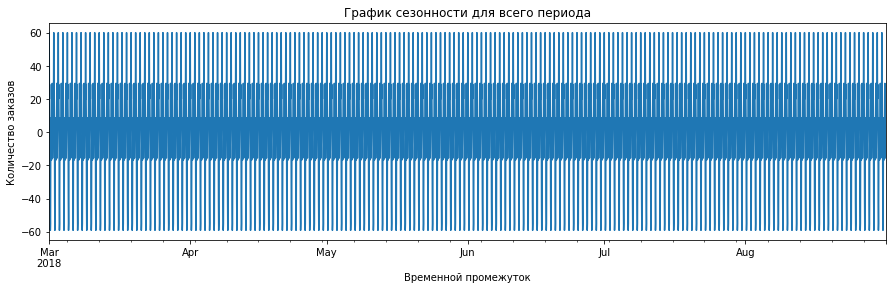

In [15]:
# Графики для всего промежутка:
decomposed.trend.plot(figsize = (15, 4))
plt.title('График тренда для всего периода')
plt.ylabel('Количество заказов')
plt.xlabel('Временной промежуток')
plt.show()

decomposed.seasonal.plot(figsize = (15, 4))
plt.title('График сезонности для всего периода')
plt.ylabel('Количество заказов')
plt.xlabel('Временной промежуток')
plt.show()

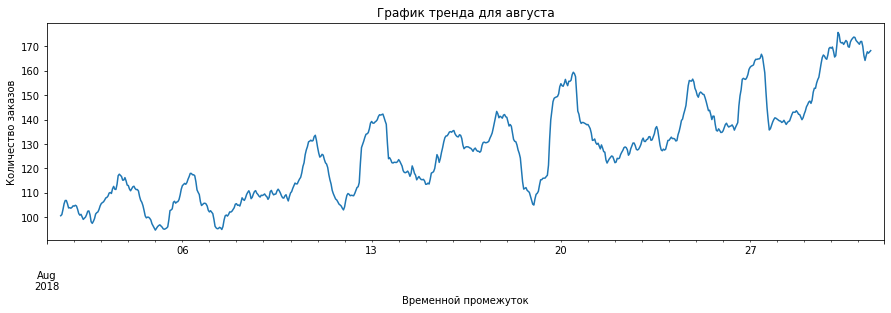

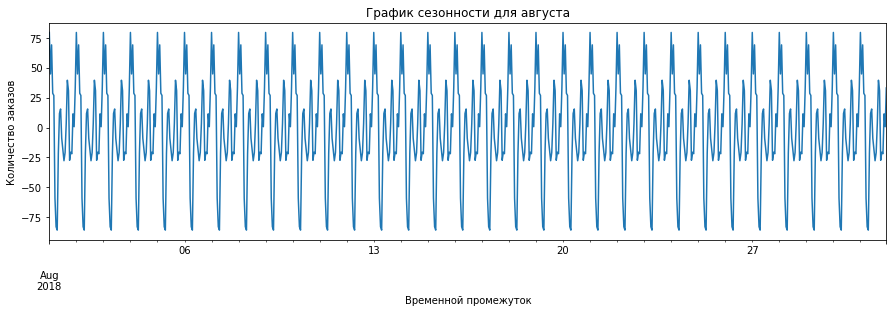

In [16]:
# Графики для августа:
decomposed_aug.trend.plot(figsize = (15, 4))
plt.title('График тренда для августа')
plt.ylabel('Количество заказов')
plt.xlabel('Временной промежуток')
plt.show()

decomposed_aug.seasonal.plot(figsize = (15, 4))
plt.title('График сезонности для августа')
plt.ylabel('Количество заказов')
plt.xlabel('Временной промежуток')
plt.show()

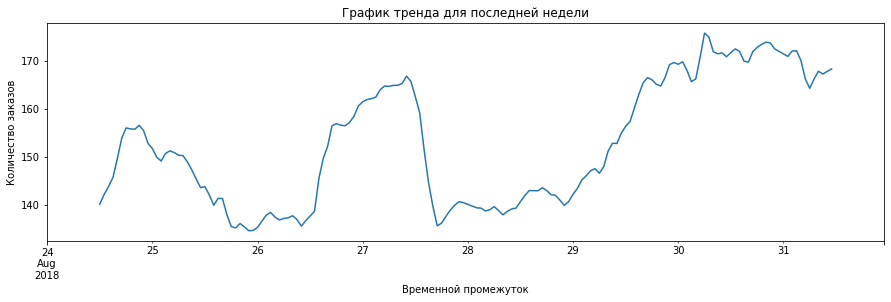

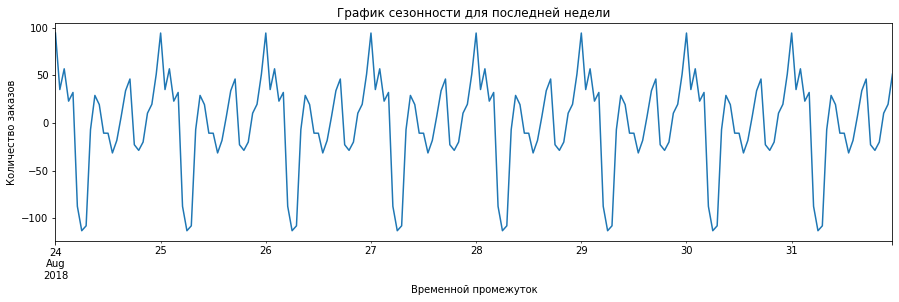

In [17]:
# Графики для последней недели:
decomposed_aug_lw.trend.plot(figsize = (15, 4))
plt.title('График тренда для последней недели')
plt.ylabel('Количество заказов')
plt.xlabel('Временной промежуток')
plt.show()

decomposed_aug_lw.seasonal.plot(figsize = (15, 4))
plt.title('График сезонности для последней недели')
plt.ylabel('Количество заказов')
plt.xlabel('Временной промежуток')
plt.show()

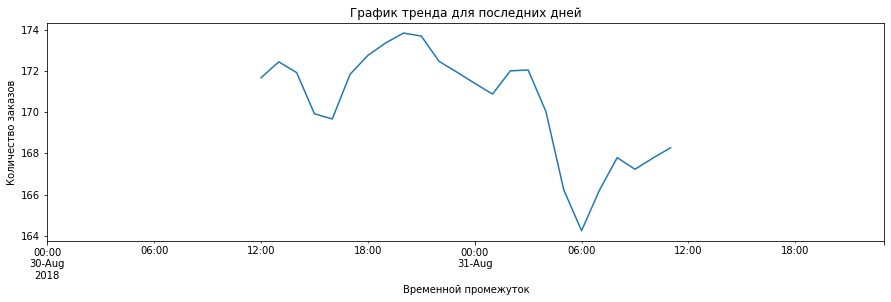

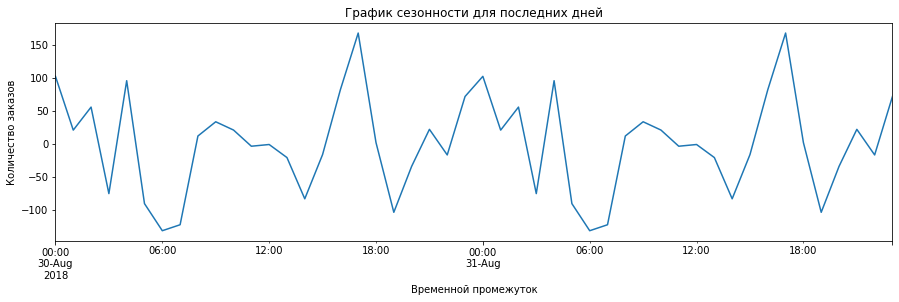

In [18]:
# Графики для последних дней:
decomposed_aug_ld.trend.plot(figsize = (15, 4))
plt.title('График тренда для последних дней')
plt.ylabel('Количество заказов')
plt.xlabel('Временной промежуток')
plt.show()

decomposed_aug_ld.seasonal.plot(figsize = (15, 4))
plt.title('График сезонности для последних дней')
plt.ylabel('Количество заказов')
plt.xlabel('Временной промежуток')
plt.show()

#### Промежуточный вывод:
Общий тренд за полгода восходящий с небольшими просадками, то же самое можно сказать и отдельно про август. График сезонности за последние 3 дня показал, что дни идентичны друг другу: с 4 до 6 утра и с 17 до 19 наблюдается спад спроса, а наибольший рост приходится на время с 14 до 17 часов.

Осталось проверить стационарность с помощью стандартного отклонения. Добавим к каждому датафрейму его график и посмотрим на него.

In [19]:
# Добавим скользящее стандартное отклонение:
df['std'] = df['num_orders'].shift().rolling(10).std()

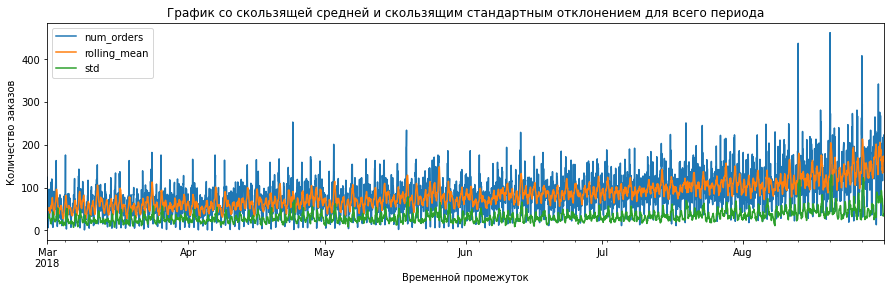

In [20]:
# Построение графика:
df.plot(figsize = (15, 4))
plt.title('График со скользящей средней и скользящим стандартным отклонением для всего периода')
plt.ylabel('Количество заказов')
plt.xlabel('Временной промежуток')
plt.show()

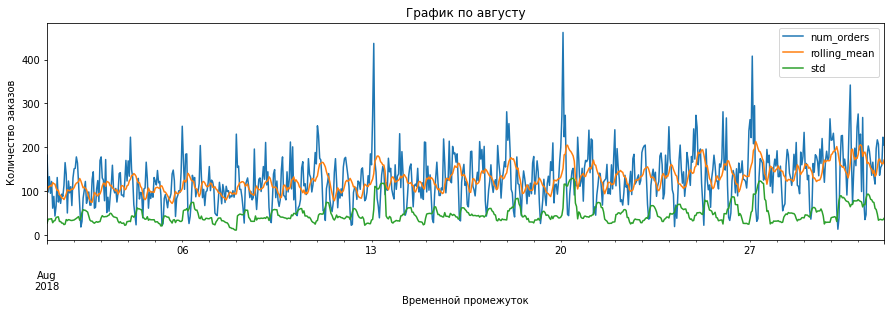

In [21]:
# График по августу:
df_aug = df['2018-08-01':]
df_aug.plot(figsize = (15, 4))
plt.title('График по августу')
plt.ylabel('Количество заказов')
plt.xlabel('Временной промежуток')
plt.show()

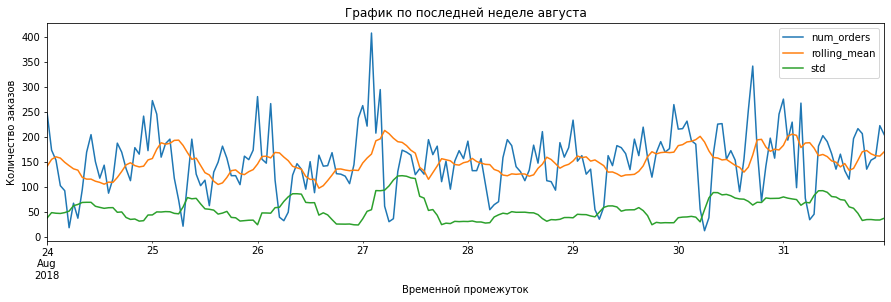

In [22]:
# График по последней неделе агуста:
df_aug_lw = df['2018-08-24':]
df_aug_lw.plot(figsize = (15, 4))
plt.title('График по последней неделе августа')
plt.ylabel('Количество заказов')
plt.xlabel('Временной промежуток')
plt.show()

Видно, что величина стандартного отклонения претерпевает сильные колебания, т.е. ряд нестационарный.

In [23]:
# Тест Дики-Фуллера:
print('P-value:', adfuller(df.num_orders)[1])
print('Alpha:', adfuller(df.num_orders)[4])

P-value: 0.028940051402612906
Alpha: {'1%': -3.431842162413052, '5%': -2.8621993540813637, '10%': -2.567120978470452}


Значение не меньше уровней значимости, значит, тест говорит о том, что ряд стационарен. С этим можно согласиться, если не учитывать выбросы.

### Вывод:
Данные за март по август (включительно) 2018 года. До августа график выглядел весьма стабильно, однако в последний месяц лета начались явные всплески заказов.

На графике за август видим три всплеска, приходящихся на 13, 20 и 27 числа. Открыв календарь, понимаем, что это понедельники. 

На последней неделе с понедельника по пятницу количество заказов было примерно одинаковым, к выходным виден рост. Также наблюдается циклический спад. Он спад приходится на раннее утро, около 6 часов.

Для оптимального сглаживания колебаний подошла скользящая с окном в 10 измерений.

Общий тренд за полгода восходящий с небольшими просадками, то же самое можно сказать и отдельно про август. График сезонности за последние 3 дня показал, что дни идентичны друг другу: с 4 до 6 утра и с 17 до 19 наблюдается спад спроса, а наибольший рост приходится на время с 14 до 17 часов.

Величина стандартного отклонения претерпевает сильные колебания, т.е. ряд нестационарный. Хотя тест Дики-Фуллера указал на обратное.

## Обучение

Переходим к обучению модели. Необходимо создать новые признаки, разделить датафрейм на выборки и обучить несколько моделей. Лучшую будем определять по результатам метрики RMSE.

In [24]:
# Функцию для подсчета RMSE зададим так для дальнейшего удобства:
def rmse(target, predicted):
    return mse(target, predicted) ** 0.5

Так как будет происходить подбор параметров, добавим функцию для построения наилучших признаков.

In [25]:
# Функция добавления признаков:
def make_features(data, max_lag, rolling_mean_size):
    data_new = data.copy()
    data_new['day'] = data_new.index.day
    data_new['dayofweek'] = data_new.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data_new['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data_new['rolling_mean'] = data_new['num_orders'].shift().rolling(rolling_mean_size).mean()
    
    return data_new

In [26]:
# Значение метрики, чтобы было, с чем сравнивать:
BEST_RMSE = 48
RANDOM_STATE = 1234

In [27]:
# Для сохранения результатов создадим класс:
class Helper:
    def __init__(self, name, model):
        """Constructor"""
        self.name = name
        self.model = model
        
    def fit(self, features, target):  
        self.model.fit(features, target)
        
    def predict(self, features, target):
        predicted = self.model.predict(features)
        self.rmse = rmse(target, predicted)
    
    def getResult(self):
        return self.name, self.rmse
    
# Сохранение результатов в списке:
finish = []

Будем сравнивать между собой модели с бустом (возьмём CatBoost и GBM) и без (линейную регрессию и дерево решений). Для каждой будет осуществляться подбор параметров.

### Модели без буста

In [28]:
# Линейная регрессия:
for max_lag in range(90, 100):
    for rolling_mean_size in range(15, 25):
        df = make_features(df, max_lag, rolling_mean_size)
        
        train, valid = train_test_split(df, shuffle = False, test_size = 0.3)
        
        train = train.dropna()
        
        X_train = train.drop('num_orders', axis = 1)
        y_train = train['num_orders']
        
        X_valid = valid.drop('num_orders', axis = 1)
        y_valid = valid['num_orders']
        
        model = LinearRegression()
        model.fit(X_train, y_train)
        prediction = model.predict(X_valid)
        
        result = rmse(y_valid, prediction)
        
        if result < BEST_RMSE:
            best_metric = result
            best_max_lag = max_lag
            best_rolling_mean_size = rolling_mean_size

In [29]:
model_lr_h = Helper('Linear regression', model)
model_lr_h.fit(X_train, y_train)
prediction = model_lr_h.predict(X_valid, y_valid)
        
finish.append(model_lr_h.getResult())

In [30]:
# Дерево решений:
for max_lag in range(1, 10):
    for rolling_mean_size in range(1, 10):
        for max_depth in range(2, 10):
            
            df = make_features(df, max_lag, rolling_mean_size)
        
            train, valid = train_test_split(df, shuffle = False, test_size = 0.3)
        
            train = train.dropna()
        
            X_train = train.drop('num_orders', axis = 1)
            y_train = train['num_orders']
        
            X_valid = valid.drop('num_orders', axis = 1)
            y_valid = valid['num_orders']
        
            model = DecisionTreeRegressor(max_depth=max_depth, random_state=RANDOM_STATE)
            model.fit(X_train, y_train)
            prediction = model.predict(X_valid)
        
            result = rmse(y_valid, prediction)
        
            if result < BEST_RMSE:
                best_metric = result
                best_max_lag = max_lag
                best_rolling_mean_size = rolling_mean_size
                best_max_depth = max_depth
                
model_dt_h = Helper('Decision Tree', model)
model_dt_h.fit(X_train, y_train)
prediction = model_dt_h.predict(X_valid, y_valid)
        
finish.append(model_dt_h.getResult())

### Модели с бустом

In [ ]:
# GBM:
for max_lag in range(1, 10):
    for rolling_mean_size in range(1, 10):
        for learning_rate in np.logspace(-5, 0, 5):
            for n_estimators in range(40, 60, 20):
                for num_leaves in range(30, 40, 10):
            
                    df = make_features(df, max_lag, rolling_mean_size)
        
                    train, valid = train_test_split(df, shuffle = False, test_size = 0.3)
            
                    train = train.dropna()
        
                    X_train = train.drop('num_orders', axis = 1)
                    y_train = train['num_orders']
        
                    X_valid = valid.drop('num_orders', axis = 1)
                    y_valid = valid['num_orders']
        
                    model = LGBMRegressor(boosting_type='gbdt', learning_rate = learning_rate, 
                                          n_estimators = n_estimators, num_leaves = num_leaves, 
                                          verbose=0, seed=RANDOM_STATE)
                    model.fit(X_train, y_train)
                    prediction = model.predict(X_valid)
        
                    result = rmse(y_valid, prediction)
        
                    if result < BEST_RMSE:
                        best_metric = result
                        best_max_lag = max_lag
                        best_rolling_mean_size = rolling_mean_size
                        best_learning_rate  = learning_rate 
                        best_n_estimators = n_estimators
                        best_num_leaves = num_leaves
                
model_gbm_h = Helper('LightGBM', model)
model_gbm_h.fit(X_train, y_train)
model_gbm_h.predict(X_valid, y_valid)

finish.append(model_gbm_h.getResult())

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002349 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002119 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002331 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002175 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.076967 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002489 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM]

In [ ]:
# CatBoost:
for max_lag in range(1, 10):
    for rolling_mean_size in range(1, 10):
        for learning_rate in np.logspace(-5, 0, 5):
            for iterations in range(39, 41, 20):
                for depth in range(7, 8, 2):
            
                    df = make_features(df, max_lag, rolling_mean_size)
        
                    train, valid = train_test_split(df, shuffle = False, test_size = 0.3)
            
                    train = train.dropna()
        
                    X_train = train.drop('num_orders', axis = 1)
                    y_train = train['num_orders']
        
                    X_valid = valid.drop('num_orders', axis = 1)
                    y_valid = valid['num_orders']
        
                    model = CatBoostRegressor(loss_function='RMSE',silent=True, learning_rate = learning_rate, 
                                          iterations = iterations, depth = depth, random_seed=RANDOM_STATE)
                    model.fit(X_train, y_train)
                    prediction = model.predict(X_valid)
        
                    result = rmse(y_valid, prediction)
            
                    if result < BEST_RMSE:
                        best_metric = result
                        best_max_lag = max_lag
                        best_rolling_mean_size = rolling_mean_size
                        best_learning_rate  = learning_rate 
                        best_iterations = iterations
                        best_depth = depth
                
model_cbr_h = Helper('CatBoost', model)
model_cbr_h.fit(X_train, y_train)
model_cbr_h.predict(X_valid, y_valid)

finish.append(model_cbr_h.getResult())

Теперь красиво выведем результаты работы и выберем лучшую модель.

In [ ]:
# Функция для красивого вывода результатов:
def nice_print(result):
    print('|{: >18}|{: >15}|'.format('Модель', 'RMSE'))
    for res in result:
        print('|{: >18}|{: >15f}|'.format(res[0], res[1]))
        
nice_print(finish)

### Вывод:
Установив константы и написав вспомогательные функции, обучили 4 модели регрессии - 2 с бустом и 2 без. Среди них были: Linear regression, Decision Tree, LightGBM, CatBoost.

Качество каждой оценивалось по предсказаниям на валидационной выборке. Лучший результат показала обычная линейная регрессия.

## Тестирование

Лучшая модель выбрана, осталось сделать на ней предсказания по тестовой выборке и посмотреть результат.

In [ ]:
# Деление на выборки:
train, test = train_test_split(df, shuffle = False, test_size = 0.1)
train = train.dropna()
        
X_train = train.drop('num_orders', axis = 1)
y_train = train['num_orders']
        
X_test = test.drop('num_orders', axis = 1)
y_test = test['num_orders']

In [ ]:
# Предсказания лучшей модели:
model = LinearRegression()
model.fit(X_train, y_train)
predictions = model.predict(X_test)
        
metric = rmse(predictions, y_test)
print('RMSE линейной регресии на тестовой выборке =',metric)

Построим график предсказанных величин и сравним его с существующими.

In [ ]:
# График предсказаний:
fig, ax = plt.subplots(figsize = (15, 4))
ax.plot(y_test.index, y_test, label = 'Реальное кол-во заказов', color = 'blue')
ax.plot(y_test.index, predictions, label = 'Предсказанное кол-во заказов', color = 'red')
plt.title('Реальные и предсказанные линейной регрессией значения тестовой выборки')
plt.xlabel('Август')
plt.ylabel('Кол-во заказов')
plt.legend()
plt.show()

Проверим адекватность нашей модели с помощью постоянных предсказаний от DummyRegressor'а.

In [ ]:
# Обучение и предсказание Dummy:
dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(X_train, y_train)
dummy_pred = dummy_regr.predict(X_test)
print('RMSE для DummyRegressor:', rmse(dummy_pred, y_test))

Метрика ниже, значит, трудились не зря.

### Вывод:
Модель линейной регрессии действительно хорошо справилась с предсказаниями. Метрика RMSE находится в допустимом диапазоне (39 < 48), график сравнения предсказаний и реальных данных выглядит неплохо.

Стоит отметить, что самые пики модель предсказать не сумела.

## Итоговый вывод:
Таблица содержит два столбца: дату и время и количество поездок. Первый был сразу переведён в индексы. Пропусков в таблице не обнаружено, тип данных корректен.

Также согласно ТЗ произвели ресемплирование по каждому часу.

Данные за март по август (включительно) 2018 года. До августа график выглядел весьма стабильно, однако в последний месяц лета начались явные всплески заказов.

На графике за август видим три всплеска, приходящихся на 13, 20 и 27 числа. Открыв календарь, понимаем, что это понедельники.

На последней неделе с понедельника по пятницу количество заказов было примерно одинаковым, к выходным виден рост. Также наблюдается циклический спад. Он спад приходится на раннее утро, около 6 часов.

Для оптимального сглаживания колебаний подошла скользящая с окном в 10 измерений.

Общий тренд за полгода восходящий с небольшими просадками, то же самое можно сказать и отдельно про август. График сезонности за последние 3 дня показал, что дни идентичны друг другу: с 4 до 6 утра и с 17 до 19 наблюдается спад спроса, а наибольший рост приходится на время с 14 до 17 часов.

Величина стандартного отклонения претерпевает сильные колебания, т.е. ряд нестационарный.

Установив константы и написав вспомогательные функции, обучили 4 модели регрессии - 2 с бустом и 2 без. Среди них были: Linear regression, Decision Tree, LightGBM, CatBoost.

Качество каждой оценивалось по предсказаниям на валидационной выборке. Лучший результат показала обычная линейная регрессия.
Модель линейной регрессии действительно хорошо справилась с предсказаниями. Метрика RMSE находится в допустимом диапазоне (39 < 48), график сравнения предсказаний и реальных данных выглядит неплохо.

Стоит отметить, что самые пики модель предсказать не сумела.

Задача выполнена в полном объёме, дополнительные исследования не требуются.